In [1]:
import numpy
import pylab as plt
import json
import torch
import pycuda.autoinit
import pycuda.driver as cuda
import tensorrt as trt
TRT_LOGGER = trt.Logger(trt.Logger.ERROR)
trt.init_libnvinfer_plugins(TRT_LOGGER, '')
import common
import onnxruntime
onnxruntime.disable_telemetry_events()
from dalle import TextTokenizer
from tqdm import tqdm


class HostDeviceMem(object):
    def __init__(self, host_mem):
        self.host = host_mem
        self.device = cuda.mem_alloc(host_mem.nbytes)
    def __str__(self):
        return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)
    def __repr__(self):
        return self.__str__()

def to_numpy(tensor):
    if isinstance(tensor, numpy.ndarray):
        return tensor
    else:
        return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def get_engine_info(engine0):
    for b in engine0:
        print(b, trt.nptype(engine0.get_binding_dtype(b)), trt.volume(engine0.get_binding_shape(b)) * engine0.max_batch_size)

with open('models/vocab.json', 'r', encoding='utf8') as f:
    vocab = json.load(f)
with open('models/merges.txt', 'r', encoding='utf8') as f:
    merges = f.read().split("\n")[1:-1]

ort_session0 = onnxruntime.InferenceSession(
    './onnx/encoder0/encoder0.onnx', 
    providers=['CPUExecutionProvider']
)
ort_session1 = onnxruntime.InferenceSession(
    './onnx/encoder1/encoder1.onnx', 
    providers=['CPUExecutionProvider']
)
ort_session2 = onnxruntime.InferenceSession(
    'engines/vqgan.onnx', 
    providers=['CPUExecutionProvider']
)

tokenizer = TextTokenizer(vocab, merges)
runtime = trt.Runtime(TRT_LOGGER)
stream = cuda.Stream()

with open("engines/decoder0.trt", mode="rb") as f:
    engine0 = runtime.deserialize_cuda_engine(f.read())
    context0 = engine0.create_execution_context()
with open("engines/decoder1.trt", mode="rb") as f:
    engine1 = runtime.deserialize_cuda_engine(f.read())
    context1 = engine1.create_execution_context()
with open("engines/decoder2.trt", mode="rb") as f:
    engine2 = runtime.deserialize_cuda_engine(f.read())
    context2 = engine2.create_execution_context()
with open("engines/srgan.trt", mode="rb") as f:
    engine3 = runtime.deserialize_cuda_engine(f.read())
    context3 = engine3.create_execution_context()

In [3]:
TEXT = 'realistic cat head with sunglasses'
TEMPERATURE = 1.0
TOPK = 256
SFACTOR = 4
SEED = 42

100%|██████████| 256/256 [00:14<00:00, 17.64it/s]


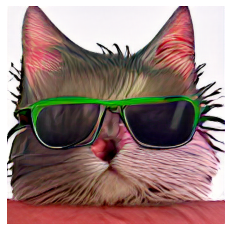

In [4]:
tokens = tokenizer.tokenize(TEXT, is_verbose=False)[:64]
image_count = 1
text_tokens = numpy.ones((2, 64), dtype=numpy.int32)
text_tokens[0, :2] = [tokens[0], tokens[-1]]
text_tokens[1, :len(tokens)] = tokens
text_tokens = torch.tensor(
    text_tokens, 
    dtype=torch.long, 
)

ort_inputs = {ort_session0.get_inputs()[0].name: to_numpy(text_tokens)}
ort_outs = ort_session0.run(None, ort_inputs)
ort_inputs = {ort_session1.get_inputs()[0].name: to_numpy(ort_outs[0]), ort_session1.get_inputs()[1].name: to_numpy(text_tokens)}
ort_outs = ort_session1.run(None, ort_inputs)
encoder_state = torch.from_numpy(ort_outs[0])

expanded_indices = [0] * image_count + [1] * image_count
text_tokens = text_tokens[expanded_indices]
encoder_state = encoder_state[expanded_indices]
attention_mask = text_tokens.not_equal(1).long()
attention_state = torch.zeros(size=(24, image_count * 4, 256, 2048))
image_tokens = torch.full((256 + 1, image_count), 16415, dtype=torch.long)
torch.manual_seed(SEED)
token_indices = torch.arange(256)
settings = torch.tensor([TEMPERATURE, TOPK, SFACTOR])
# init cuda
stream = cuda.Stream()
tAM = HostDeviceMem(cuda.pagelocked_empty(128 * image_count, numpy.int32))
tES = HostDeviceMem(cuda.pagelocked_empty(262144 * image_count, numpy.float32))
tIT = HostDeviceMem(cuda.pagelocked_empty(1 * image_count, numpy.int32))
tTI = HostDeviceMem(cuda.pagelocked_empty(1, numpy.int32))
tDS = HostDeviceMem(cuda.pagelocked_empty(4096 * image_count, numpy.float32))
tOut = HostDeviceMem(cuda.pagelocked_empty(32832 * image_count, numpy.float32))
tAS0 = HostDeviceMem(cuda.pagelocked_empty(16777216 * image_count, numpy.float32))
tAS1 = HostDeviceMem(cuda.pagelocked_empty(16777216 * image_count, numpy.float32))
tAS2 = HostDeviceMem(cuda.pagelocked_empty(16777216 * image_count, numpy.float32))

numpy.copyto(tAM.host, to_numpy(attention_mask).ravel())
numpy.copyto(tES.host, to_numpy(encoder_state).ravel())
numpy.copyto(tAS0.host, to_numpy(attention_state[:8]).ravel())
numpy.copyto(tAS1.host, to_numpy(attention_state[8:16]).ravel())
numpy.copyto(tAS2.host, to_numpy(attention_state[16:]).ravel())
cuda.memcpy_htod_async(tAM.device, tAM.host, stream)
cuda.memcpy_htod_async(tES.device, tES.host, stream)
cuda.memcpy_htod_async(tAS0.device, tAS0.host, stream)
cuda.memcpy_htod_async(tAS1.device, tAS1.host, stream)
cuda.memcpy_htod_async(tAS2.device, tAS2.host, stream)

for i in tqdm(range(256)):
    numpy.copyto(tIT.host, to_numpy(image_tokens[i]).ravel())
    numpy.copyto(tTI.host, to_numpy(token_indices[[i]]).ravel())
    cuda.memcpy_htod_async(tIT.device, tIT.host, stream)
    cuda.memcpy_htod_async(tTI.device, tTI.host, stream)
    queue = [tAM, tES, tAS0, tIT, tTI, tDS, tAS0]
    context0.execute_async_v2(bindings=[v.device for v in queue], stream_handle=stream.handle)
    stream.synchronize()
    queue = [tAM, tES, tDS, tAS1, tTI, tDS, tAS1]
    context1.execute_async_v2(bindings=[v.device for v in queue], stream_handle=stream.handle)
    stream.synchronize()
    queue = [tAM, tES, tDS, tAS2, tTI, tAS2, tOut]
    context2.execute_async_v2(bindings=[v.device for v in queue], stream_handle=stream.handle)
    cuda.memcpy_dtoh_async(tOut.host, tOut.device, stream)
    stream.synchronize()
    logits = torch.from_numpy(tOut.host).reshape(2, 1, 16416)
    logits = logits[:, -1, : 2 ** 14]
    temperature = settings[[0]]
    top_k = settings[[1]].to(torch.long)
    supercondition_factor = settings[[2]]
    logits = (
        logits[:image_count] * (1 - supercondition_factor) + 
        logits[image_count:] * supercondition_factor
    )
    logits_sorted, _ = logits.sort(descending=True)
    is_kept = logits >= logits_sorted[:, top_k - 1]
    logits -= logits_sorted[:, [0]]
    logits /= temperature
    logits.exp_()
    logits *= is_kept.to(torch.float32)
    image_tokens[i + 1] = torch.multinomial(logits, 1)[:, 0]

ort_inputs = {ort_session2.get_inputs()[0].name: to_numpy(image_tokens[1:].T)}
images = ort_session2.run(None, ort_inputs)[0]

image_outputs = []
for i in range(images.shape[0]):
    inputs, outputs, bindings = common.allocate_buffers(engine3)
    numpy.copyto(inputs[0].host, numpy.moveaxis(images[i][None], -1, 1).ravel() / 255.)
    img = common.do_inference(context3, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)[0]
    img = numpy.moveaxis(img.reshape(3,1024,1024), 0, -1).clip(0, 1)
    image_outputs.append(img)

for img in image_outputs:
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [5]:
from PIL import Image
Image.fromarray((image_outputs[0] * 255.).astype(numpy.uint8)).save('demo.png')